# Cohere for event listing
In this notebook, I set up a simple workflow for an agent to suggest some cool events from the [Boston Calendar](https://www.thebostoncalendar.com/). It uses LangChain's wrapper for Cohere's Command-R+ API.  

I also perform an experiment comparing styling information in the preamble to a post-result styling.  

The result indicates that there may be benefit in separating the tasks.  I did not conduct the experiment here, but potentially a lighter-weight model could be asked to do the styling while the more complex model conducts the agent workflow.

In [1]:
from langchain_cohere import ChatCohere, create_cohere_react_agent
from langchain.agents import (
    tool, 
    AgentExecutor
)
from langchain_core.prompts import PromptTemplate
from datetime import datetime, date
from langchain_core.output_parsers import StrOutputParser

# some requirements for arguments
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.runnables import RunnablePassthrough
import matplotlib.pyplot as plt


# this is for simple scraping tool
import requests
from random import sample
from bs4 import BeautifulSoup

In [ ]:
# using .env file for cohere API key
from dotenv import load_dotenv
import os
load_dotenv()
# trial key
llm = ChatCohere(model="command-r-plus", cohere_api_key=os.getenv("COHERE_KEY"))

### Working example
This section has all the code you need to run the "winning" approach; a post-workflow styling.  I only experimented with the current set of parameters, but switching these up should not break the workflow.

In [24]:
# define style ("Rewrite in the style of...")
style = "an angry pirate"
# what are you asking the agent to do
# this is for upcoming events, other types of questions may not work
user_prompt = "What is going on this weekend?"

In [22]:
# define the function calls for our tools
@tool
def today(text: str = 's') -> dict:
    """Returns today's date, use this when you need to get today's date.
    The input should always be an empty string."""
    # has to return a dictionary
    return {'today': str(date.today())}

def parse_for_calendar(text: str) -> str:
    # utility for converting text input to boston calendar URL
    if len(text) == 1:
        # will assume this month if we're looking at weekend number
        today = datetime.now()
        month = today.month
        day = today.day
        url = f'https://www.thebostoncalendar.com/events?day={day}&month={month}&weekend={text}&year=2024'
    # this will fail if the string provided is not a date
    else:
        try:
            f_date = datetime.strptime(text, '%Y-%M-%d')
            day_of_month = f_date.day
            month = f_date.month
            url = f'https://www.thebostoncalendar.com/events?day={day_of_month}&month={month}&year=2024'
        except ValueError:
            return 
    return url

@tool
def weekend(text: str = '') -> dict:
    """Returns the single-digit weekend number for this weekend, \
    use this for any questions related to the weekend date. \
    The input should always be an empty string, \
    and this function will always return the weekend number."""
    today = datetime.now()
    
    # Calculate the weekend number within the month
    first_day_of_month = today.replace(day=1)
    weekend_number_within_month = (today - first_day_of_month).days // 7 + 1

    #return weekend_number_within_month
    # has to return a dictionary
    return {'weekend_number': weekend_number_within_month}

@tool
def get_events(text: str) -> dict:
    """Returns local events. \ 
    The input is either a date string in the format YYYY-MM-DD, \
    or it is a single-digit weekend number.\
    The input cannot be a function call.\
    This function will return a list where \
    each element contains an event name, date and location as a tuple.\
    This function should be used to provide complete information about events."""
    # use the parsing utility to get a formatted url
    url = parse_for_calendar(text)
    if url is None:
        # give the LLM a useful response
        return {'events': 
                f'Input "{text}" is not in the right format - it needs to be a date string or a weekend number'}
    response = requests.get(url)     
    
    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract data
    events = soup.find_all('div', class_='info')

    all_events = []
    for event in events:
        title = event.find('h3').text.strip()
        date = event.find('p', class_='time').text.strip()
        location = event.find('p', class_='location').text.strip()
        all_events.append((title, date, location))

    # randomly select a few, provide as list
    choices = sample(all_events, 3)
    
    #return choices
    # has to return a dictionary
    return {'events': choices}

def run_agent(agent_details, prompt="What is going on this weekend?"):
    result = agent_details['executor'].invoke({
        "input": prompt,
        "preamble": agent_details['preamble'],
    })
    return result

class empty_string(BaseModel):
    text: str = Field(description="Empty string input", required=False, default='')
    @validator("text")
    def is_empty(cls, field):
        if field is None:
            return ''
        return field

class date_input(BaseModel):
    text: str = Field(description="Date string in the format YYYY-MM-DD or weekend number (e.g. 1)")

today.args_schema = empty_string
weekend.args_schema = empty_string
get_events.args_schema = date_input

tools = [today, weekend, get_events]

preamble = """You are an expert who answers the user's question with the most relevant datasource. \
You are equipped with tools for getting date information and looking for upcoming events."""

prompt = PromptTemplate.from_template("{input}")
agent = create_cohere_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, 
                                verbose=False, 
                                handle_parsing_errors=True,
                                max_iterations=5)

styling_prompt = f'Rewrite the following as if you are {style}:\n' + '{events_output}'
styling_template = PromptTemplate.from_template(styling_prompt)

full_pipe = {'executor': {'events_output': agent_executor, 'input': RunnablePassthrough()} | 
                               styling_template | 
                               llm | StrOutputParser(),
                               'preamble': preamble}

#### Run the workflow

In [23]:
run_agent(full_pipe, prompt=user_prompt)

"Argh, ye scurvy dog! Listen up, ye landlubber! It be Sunday, April 6 of the year 2024. And mark me words, there be a single event happenin' today that ye might be interested in, given yer penchant fer cheap travel: \n\n$10 Commuter Rail Weekends in Boston, startin' at 5:00 am. \n\nNow, ye best be mindful o' the time, or ye might miss the chance fer a cheap voyage! Arrrr!"

### Experiment details
This code is for running the experiment I used to determine the "winning" approach

#### Defining the tools
Here are the tools with which I want to equip the LLM.

In [25]:
# define the function calls for our tools
@tool
def today(text: str = 's') -> dict:
    """Returns today's date, use this when you need to get today's date.
    The input should always be an empty string."""
    # has to return a dictionary
    return {'today': str(date.today())}

def parse_for_calendar(text: str) -> str:
    # utility for converting text input to boston calendar URL
    if len(text) == 1:
        # will assume this month if we're looking at weekend number
        today = datetime.now()
        month = today.month
        day = today.day
        url = f'https://www.thebostoncalendar.com/events?day={day}&month={month}&weekend={text}&year=2024'
    # this will fail if the string provided is not a date
    else:
        try:
            f_date = datetime.strptime(text, '%Y-%M-%d')
            day_of_month = f_date.day
            month = f_date.month
            url = f'https://www.thebostoncalendar.com/events?day={day_of_month}&month={month}&year=2024'
        except ValueError:
            return 
    return url

@tool
def weekend(text: str = '') -> dict:
    """Returns the single-digit weekend number for this weekend, \
    use this for any questions related to the weekend date. \
    The input should always be an empty string, \
    and this function will always return the weekend number."""
    today = datetime.now()
    
    # Calculate the weekend number within the month
    first_day_of_month = today.replace(day=1)
    weekend_number_within_month = (today - first_day_of_month).days // 7 + 1

    #return weekend_number_within_month
    # has to return a dictionary
    return {'weekend_number': weekend_number_within_month}

@tool
def get_events(text: str) -> dict:
    """Returns local events. \ 
    The input is either a date string in the format YYYY-MM-DD, \
    or it is a single-digit weekend number.\
    The input cannot be a function call.\
    This function will return a list where \
    each element contains an event name, date and location as a tuple.\
    This function should be used to provide complete information about events."""
    # use the parsing utility to get a formatted url
    url = parse_for_calendar(text)
    if url is None:
        # give the LLM a useful response
        return {'events': 
                f'Input "{text}" is not in the right format - it needs to be a date string or a weekend number'}
    response = requests.get(url)     
    
    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract data
    events = soup.find_all('div', class_='info')

    all_events = []
    for event in events:
        title = event.find('h3').text.strip()
        date = event.find('p', class_='time').text.strip()
        location = event.find('p', class_='location').text.strip()
        all_events.append((title, date, location))

    # randomly select a few, provide as list
    choices = sample(all_events, 3)
    
    #return choices
    # has to return a dictionary
    return {'events': choices}

class empty_string(BaseModel):
    text: str = Field(description="Empty string input", required=False, default='')
    @validator("text")
    def is_empty(cls, field):
        if field is None:
            return ''
        return field

class date_input(BaseModel):
    text: str = Field(description="Date string in the format YYYY-MM-DD or weekend number (e.g. 1)")

today.args_schema = empty_string
weekend.args_schema = empty_string
get_events.args_schema = date_input

tools = [today, weekend, get_events]

#### Defining the agent structures
I try out several agent structures here.  The main thing I want to test is how styling within the preamble or styling the result change the helpfulness/robustness of the workflow


In [26]:
preamble = """You are an expert who answers the user's question with the most relevant datasource. \
You are equipped with tools for getting date information and looking for upcoming events."""

agent_options = {}
verbose = False
prompt = PromptTemplate.from_template("{input}")
agent = create_cohere_react_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, 
                                verbose=verbose, 
                                handle_parsing_errors=True,
                                max_iterations=5)
agent_options['base'] = {'executor': agent_executor,
                         'preamble': preamble}

# define style
style = "an angry pirate"
# style in preamble
style_preamble= preamble + f'\nRespond in the style of {style}.'
agent_options['preamble_style'] = {'executor': agent_executor,
                         'preamble': style_preamble}

styling_prompt = f'Rewrite the following as if you are {style}:\n' + '{events_output}'
styling_template = PromptTemplate.from_template(styling_prompt)

agent_options['post_style'] = {'executor': {'events_output': agent_executor, 'input': RunnablePassthrough()} | styling_template | llm | StrOutputParser(),
                               'preamble': preamble}

In [27]:
def eval_result(result, llm=llm):
    # evaluation prompt
    eval_prompt = """The user has requested information about upcoming events. \
    The following is a response to this request. \
    Evaluate the quality of the response. \
    Respond with one word, either "good" or "bad"."""
    prompt = PromptTemplate.from_template(f"{eval_prompt}:\n{result}")
    eval_pipe = prompt | llm | StrOutputParser()
    eval_result = eval_pipe.invoke({'result': result})
    # process output
    output = {}
    output['raw'] = eval_result
    if 'good' in eval_result.lower():
        output['good'] = True
    elif 'bad' in eval_result.lower():
        output['good'] = False
    return output

def run_agent(agent_details, prompt="What is going on this weekend?"):
    result = agent_details['executor'].invoke({
        "input": prompt,
        "preamble": agent_details['preamble'],
    })
    return result

#### Running the experiment!

In [28]:
# how many times to iterate
iter_num = 10
# iterate through the preamble dictionary
eval_collect = []
result_collect = []
for opt in agent_options:
    print(f"Using preamble: {opt}")
    for i in range(iter_num):
        print(f"Iteration {i+1}")
        try:
            result = run_agent(agent_options[opt])
        except TooManyRequestsError:
            print("Too many requests, waiting")
            time.sleep(60)
            result = run_agent(agent_options[opt])
        # capture other exceptions
        except Exception as e:
            print(f"Error: {e}")
            continue
        if 'output' in result:
            result_text = result['output']
        else:
            result_test = result
        result_collect.append(result_text)
        eval_output = eval_result(result_text)
        eval_collect.append((opt, eval_output))

Using preamble: base
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Using preamble: preamble_style
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Using preamble: post_style
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Error: peer closed connection without sending complete message body (incomplete chunked read)
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Error: The read operation timed out


In [6]:
eval_collect[0]

NameError: name 'eval_collect' is not defined

Text(0.5, 1.0, 'Preamble performance')

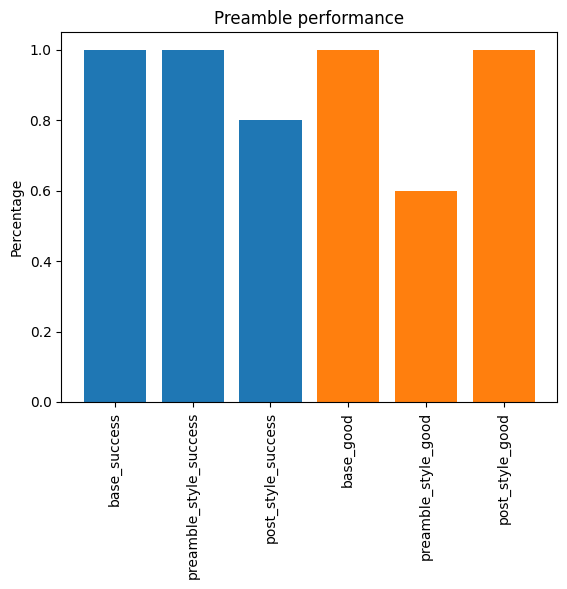

In [34]:
# consolidate and visualize results
from collections import defaultdict
opt_count = defaultdict(int)
opt_good = defaultdict(int)
for opt, eval_result in eval_collect:
    if eval_result['good']:
        opt_good[opt] += 1
    opt_count[opt] += 1
# combine count and good pct side by side
opt_pct = {k: v/iter_num for k, v in opt_count.items()}
opt_good_pct = {k: v/opt_count[k] for k, v in opt_good.items()}
# plot
fig, ax = plt.subplots()
ax.bar([f'{k}_success' for k in opt_pct.keys()], opt_pct.values())
ax.bar([f'{k}_good' for k in opt_good_pct.keys()], opt_good_pct.values())
# rotate x labels
plt.xticks(rotation=90)
ax.set_ylabel('Percentage')
ax.set_title('Preamble performance')
